# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Dataset
[Dataset] is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Dataset can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with game, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the project/milestone-02/m2_dataset_sciper.ipynb.

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [36]:
# Imports
#BKT
from pyBKT.models import Model

#SHAP
import shap
import utils_lgbm
import lightgbm as lgb

import importlib
importlib.reload(utils_lgbm)

# plots
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import tqdm
import seaborn as sns

# data
import numpy as np
import pandas as pd
import re
import math

# graph
import networkx as nx
from networkx.drawing.nx_agraph import read_dot

In [37]:
# helper methods
from utils import get_nodes, get_skill_id_ranks, choose_ranking, find_user_subtasks, calculate_mastery_level, find_word_in_list, get_random_ids, convert_to_csv, load_from_csv

In [38]:
# Import the tables of the data set as dataframes.

DATA_DIR = './data' 

# You can use the nrows=X argument in pd.read_csv to truncate your data
users = pd.read_csv('{}/small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/small_subtasks.csv'.format(DATA_DIR), index_col=0)

## Task 0: Research Question

**Research question:**
* What factors influence the process of learning? Is the time most important? How many correct answers? 

* How do we define mastery to determine how much the students are learning? Is there a difference between predicting mastery and change in mastery level?

* Which models perform best at Knowledge tracing (BKT vs LGBM vs Transformers) ?

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [4]:
# In subtasks dataset exist more event_id than in events dataset
print(f'How many events in dataset: {len(events)}')
print(f'How many subtasks in dataset: {len(subtasks)}')
subtasks = subtasks[subtasks.event_id < len(events)]

How many events in dataset: 34094
How many subtasks in dataset: 55047


### Skill graph
We decide to base calculation of the mastery in games on skill graph, which we are downloading below.

In [5]:
# Read the DOT file and store it as a NetworkX graph
dot_file_path = 'data/04_skill_map_dot_file.dot'
G = read_dot(dot_file_path)

In [8]:
# Draw graph of skills
def draw_graph(G):
    plt.figure(figsize=(40, 80))
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    node_sizes = [len(G.adj[node]) * 100 for node in G.nodes]
    edge_widths = [1 + len(G.get_edge_data(u, v)) for u, v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.5)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3, arrowsize=10, arrowstyle='->')
    labels = {node: node.replace('\n', ' ') for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    plt.axis('off')
    plt.savefig('skill_graph')
    plt.close()

draw_graph(G)

![myfig](skill_map.png)

### Dataframe with mastery levels
At the beginning, we are looking for the games titles in skill map, which fits with game name and skill id found in the dataframe. Then we have to find ancestors of the each game, based on position in the skill map. Thanks to this we can calculate the mastery skill over all games that contributes to development of each skill for all the users.

To calculate mastery level we are using methods from utils.py. They are described in comments.

Finally we stored created dataframe in dataframe.csv file

In [9]:
# Create dataframe with multindex [user_id, week, game]
def create_dataframe_multi_index(G, how_many=100, verbose=False):

    # Create empty dataframe
    multi_index = [[], [], []]
    df = pd.DataFrame(columns = ['mastery_level', 'mastery_level_diff'], index = multi_index)
    df.index = df.index.set_names(['user_id', 'game_name', 'week'])

    subtasks_events = subtasks.merge(events, on='event_id')

    # Create users iterator
    users_iterator = tqdm.tqdm(users.iterrows(), total=len(users), colour='#C83D95') if verbose else users.iterrows()

    for user_id, user in users_iterator:
        # Find user_subtasks 
        user_subtasks = find_user_subtasks(subtasks_events, user_id)[['week_number', 'game_name', 'skill_id', 'correct']]
        
        # Create index for the user:
        # Get unique games names
        game_names = events.loc[subtasks['event_id']]['game_name'].unique()

        # Get unique weeks
        unique_weeks = user_subtasks['week_number'].unique()

        len_weeks = len(unique_weeks)
        len_game_names = len(game_names)

        user_ids = [user_id for i in range(len_weeks * len_game_names)]

        user_unique_weeks = user_subtasks['week_number'].unique()
        user_unique_weeks = np.concatenate([user_unique_weeks]* (len_game_names))

        user_unique_games = [game for game in game_names for week in range(len_weeks)]

        tuples = list(zip(user_ids, user_unique_games, user_unique_weeks))

        # Assign index values
        index = pd.MultiIndex.from_tuples(tuples, names=['user_id', 'game_name', 'week'])
        user_df = pd.DataFrame(columns = ['mastery_level', 'mastery_level_diff'], index = index)

        # Calculate mastery level
        mastery_level = []
        for game in game_names:
            for week in unique_weeks:
                # Find info about statistics of the user for the game for the week
                associated_events = user_subtasks[(user_subtasks['game_name'] == game) & (user_subtasks['week_number'] == week)]
                
                # If the user played the game during the week
                if not associated_events.empty:
                    mean_skill = associated_events['skill_id'].mean()
                    lv = calculate_mastery_level(G, user_subtasks, week, game, mean_skill)
                    mastery_level.append(lv)
                # If the user did not play the game during the week, but we can get previous statictics
                elif week > unique_weeks[0]:
                    mastery_level.append(mastery_level[-1])
                # If the week == 1 and player did not play the game
                else: 
                    mastery_level.append(0.0)
                

        # Assign mastery levls
        mastery_level = pd.DataFrame(mastery_level, columns = ['mastery_level'])
        mastery_level.index = index
        user_df['mastery_level'] = mastery_level

        # Assign the difference of mastery lvls
        user_df['mastery_level_diff'] = user_df['mastery_level'].diff()
        user_df.loc[user_df.index.get_level_values('week') == 1, 'mastery_level_diff'] = 0.0

        # Add stats of the user to the dataframe
        df = pd.concat([df, user_df], axis=0)

        # process for chosen part of users dataframe
        if user_id > how_many:
            break
    return df

df = create_dataframe_multi_index(G, len(users), True)
convert_to_csv(df, 'dataframe.csv')

100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


In [39]:
df = load_from_csv('dataframe.csv')
df.head()

mastery_level  mastery_level_diff
user_id game_name  week                                   
1       Subitizing 1           1.00000             0.00000
                   2           1.00000             0.00000
                   3           1.00000             0.00000
                   4           1.00000             0.00000
                   5           1.00000             0.00000

### Display results
We are creating two graphs, each of them showing one column in our dataframe for 10 users for chosen game. 
- mastery_level: it is representation of development of skill over time
- mastery_level_diff: it represents the progress between each week over time

In [7]:
# Display mastery levels
def show_mastery_details(df, users, game, col):
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, user in enumerate(users):
        temp_df = df.sort_index().loc[(user, game), :]
        ax.plot(temp_df.index, temp_df[col], label=f'{user}')

    ax.set_title(f'{col} of {game} Over Time')
    ax.set_xlabel('Weeks')
    ax.set_ylabel(col)
    ax.legend(title='User ID', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.savefig(f'{col}.png')
    plt.close()

random_user_ids = get_random_ids(df, 10, 'Subitizing', 'mastery_level_diff')
show_mastery_details(df, random_user_ids, 'Subitizing', 'mastery_level')

#random_user_ids = get_random_ids(df, 10, 'Subitizing', 'mastery_level_diff')
show_mastery_details(df, random_user_ids, 'Subitizing', 'mastery_level_diff')

#### Mastery level
We can track the progress or regress of developing of the skill, what is important not many users achieve the mastery level above 0.5 at the end of their learning, so it may mean that they drop the learning process because of some reasons, which could be boredom or lack of motivation to continue.

![mastery_level](mastery_level.png)

#### Mastery level differences
What is of much significance, most of users are not making progress during all the period of research. They only play the game in some of the weeks, where in others they are not progressing at all. This could provide us some insights why they are not making great progess which can be observed in first plot. Also the differences between mastery levels over weeks are not better than 0.1, usually they are below zero. The ratio between how much of them making progress and regress is small, according to the fact most of differences are negative.

![mastery_level_diff](mastery_level_diff.png)

We can conclude that the values of these columns and patterns that can be found in this graphs are completely different. These will be used to check which allows us to produce better predictions, as the first one might be misinterpreted by our model, because even though player is not playing the game his mastery skill is maintained.


## Task 2: Model Building

We will train two model for this part: BKT and LGBM, the first one serving as a baseline model.

**Research question:**
* What factors influence the process of learning? Is the time most important? How many correct answers? 
* How do we define mastery to determine how much the students are learning? Is there a difference between predicting mastery and change in mastery level?
* Which models perform best at Knowledge tracing (BKT vs LGBM vs Transformers) ?

### Training baseline model: BKT

- First model: based on the "correct" value, forget=False trained for all games
- Second model: based on the "correct" value, forget=True trained for all games
- Third model: based on the cumulative percent correct value trained for all games 
- Fourth model: based on the "correct" value trained for each skill id


In [40]:
# Loading preprocessed dataframe generated in experiment.ipynb
# Unamed:0 is the index column of the dataframe before preprocessing (many rows where removed)
df_task_events = pd.read_csv('data/small_task_events.csv')
df_task_events.rename(columns={'game_name': 'skill_name'}, inplace=True)
df_task_events.head()

,Unnamed: 0,event_id,user_id,mode_event,skill_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,correct,level_2,cumulative_percent_correct
0,0,118,7,NORMAL,Subitizing,R10,1.00000,ConciseTimeoutDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,135,1.00000
1,1,118,7,NORMAL,Subitizing,R10,1.00000,ConciseSubitizingTaskDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,134,1.00000
2,2,119,7,NORMAL,Conversion,R10,3.00000,ConciseConversionTaskDescription,2015-03-20 18:07:17.288000+00:00,2015,12,5,0,True,136,1.00000
3,3,120,7,NORMAL,Landing,R10,19.00000,ConciseLandingTaskDescription,2015-03-23 15:18:26.515000+00:00,2015,13,1,1,True,137,1.00000
4,4,121,7,END_OF_NR,Conversion,R10,7.00000,ConciseConversionTaskDescription,2015-04-02 14:03:06.836000+00:00,2015,14,4,2,True,138,1.00000


##### First BKT model (using correct and forget=False)

In [43]:
# Creating the first model with default parameters and fitting it for all games
bkt_1 = Model(seed=0)
bkt_1.fit(data=df_task_events, forgets=False)
bkt_1_auc = bkt_1.evaluate(data=df_task_events, metric='auc') 
bkt_1_auc

0.7762680155021282

In [44]:
# Vizualizing parameters
bkt_1.params().head(10)

value
skill      param   class          
Subitizing prior   default 0.85219
           learns  default 0.16999
           guesses default 0.23163
           slips   default 0.25181
           forgets default 0.00000
Conversion prior   default 0.88217
           learns  default 0.07011
           guesses default 0.61837
           slips   default 0.10315
           forgets default 0.00000

##### Second BKT model (using correct and forget=True)

In [45]:
# Creating the second model with forgets=True and fitting it for all games
bkt_2 = Model(seed=0)
bkt_2.fit(data=df_task_events, forgets=True)
bkt_2_auc = bkt_2.evaluate(data=df_task_events, metric='auc')
bkt_2_auc

0.7832315942118101

In [46]:
# Vizualizing parameters
bkt_2.params().head(10)

value
skill      param   class          
Subitizing prior   default 0.84040
           learns  default 0.56953
           guesses default 0.00844
           slips   default 0.19776
           forgets default 0.08222
Conversion prior   default 0.85845
           learns  default 0.29316
           guesses default 0.59861
           slips   default 0.07647
           forgets default 0.05330

##### Third BKT model (using cumulative percent correct and forget=True)

In [57]:
# Building the dataframe for the third model, where we will use the cumulative percent correct feature
df_test = df_task_events.copy()
df_test.drop('correct', axis=1, inplace=True)
df_test.rename(columns={"cumulative_percent_correct":"correct"}, inplace=True)
df_test.head()

,Unnamed: 0,event_id,user_id,mode_event,skill_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,level_2,correct,correct_predictions,state_predictions
50463,54328,0,1,NORMAL,Subitizing,R10,1.00000,ConciseSubitizingTaskDescription,2022-11-02 08:39:12.355000+00:00,2022,44,3,0,0,1.00000,0.67555,0.84040
50464,54329,0,1,NORMAL,Subitizing,R10,1.00000,ConciseTimeoutDescription,2022-11-02 08:39:12.355000+00:00,2022,44,3,0,1,1.00000,0.73642,0.91708
50952,54340,1,1,NORMAL,Conversion,R10,4.00000,ConciseConversionTaskDescription,2022-11-11 10:26:27.893000+00:00,2022,45,5,1,2,1.00000,0.87753,0.85845
51366,54331,2,1,NORMAL,Conversion,R10,7.00000,ConciseConversionTaskDescription,2022-11-18 10:34:01.044000+00:00,2022,46,5,2,3,1.00000,0.88570,0.88359
51742,54330,3,1,NORMAL,Landing,R10,19.00000,ConciseLandingTaskDescription,2022-11-25 10:32:43.428000+00:00,2022,47,5,3,4,0.00000,0.38122,0.14052


In [49]:
bkt_3 = Model(seed=0)
bkt_3.fit(data=df_test, forgets=True)
bkt_3_auc = bkt_3.evaluate(data=df_test, metric='auc')
bkt_3_auc

0.9107736063295553

In [50]:
bkt_3.params().head()

value
skill      param   class          
Subitizing prior   default 0.67984
           learns  default 0.01306
           guesses default 0.00260
           slips   default 0.00253
           forgets default 0.26471

##### Fourth model: fitting it for each skill id

In [51]:
# To fit the BKT model for each skill id we build a dataframe with the skill id as the skill name
df_bkt_per_skill = df_task_events.copy()
df_bkt_per_skill.rename(columns={'skill_name':'original_skill_name', 'skill_id':'skill_name'}, inplace=True)
df_bkt_per_skill["skill_name"] = df_bkt_per_skill["skill_name"].astype(str)

auc_per_skill = {}
nan_counter = 0
bkt_skill = Model(seed=0)
for skill in events['skill_id'].unique():
    # We skip the skill ids that have a nan value
    if np.isnan(skill):
        nan_counter += 1
        continue
    else:
        bkt_skill.fit(data=df_bkt_per_skill, skills=str(skill), forgets=True)
        auc_per_skill[skill]= bkt_skill.evaluate(data=df_bkt_per_skill, metric='auc')

print(f'Number of nan values: {nan_counter}')

Number of nan values: 1


#### Predicting student's mastery level with BKT

In [52]:
# Predicting mastery levels for all users for the first model
# state_predictions: score between 0 and 1 that measures the extent to which the student has mastered that skill, after that question
# correct_predictions: score between 0 and 1 that measures the extent to which the model thinks that the student will answer correctly to that question
bkt_1_preds = bkt_1.predict(data=df_task_events)
bkt_1_preds[['user_id', 'skill_name', 'correct', 'correct_predictions', 'state_predictions']].head()

,user_id,skill_name,correct,correct_predictions,state_predictions
50463,1,Subitizing,1,0.67184,0.85219
50464,1,Subitizing,1,0.72634,0.95770
50952,1,Conversion,1,0.86404,0.88217
51366,1,Conversion,1,0.87502,0.92159
51742,1,Landing,0,0.38756,0.37015


In [53]:
# Predicting mastery level for all users for the second model
bkt_2_preds = bkt_2.predict(data=df_task_events)
bkt_2_preds[bkt_2_preds['skill_name']=='Landing'][['user_id', 'correct', 'correct_predictions', 'state_predictions']].head()

,user_id,correct,correct_predictions,state_predictions
51742,1,0,0.38122,0.14052
53936,1,1,0.50325,0.37233
54302,1,1,0.59853,0.55333
54907,1,1,0.62386,0.60145
49587,2,0,0.38122,0.14052


In [58]:
# Predicting mastery level for all users for the third model
bkt_3_preds = bkt_3.predict(data=df_test)
bkt_3_preds[['user_id', 'skill_name', 'correct', 'correct_predictions', 'state_predictions']].head()

,user_id,skill_name,correct,correct_predictions,state_predictions
50463,1,Subitizing,1,0.67895,0.67984
50464,1,Subitizing,1,0.73324,0.73441
50952,1,Conversion,1,0.86931,0.86451
51366,1,Conversion,1,0.87745,0.87919
51742,1,Landing,0,0.44909,0.75865


The first model is predicts student mastery more rappidly than the other two models, if we assumes that students are not forgeting the skill, indeed they will aquire the skill more rappidly.  

#### Visualizing results

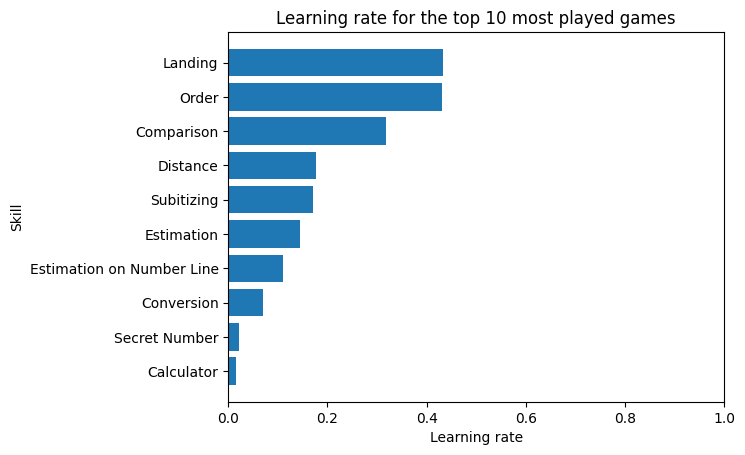

In [55]:
bkt_1_params = bkt_1.params().reset_index()

# top 10 games with the highest number of users
df_top10_most_played_games = df_task_events['skill_name'].value_counts().head(10)

# Plot learning rate for the top 10 games
df_learning = bkt_1_params[bkt_1_params['param'] == 'learns'][['skill', 'value']]
df_learning_top10_games = df_learning[df_learning['skill'].isin(df_top10_most_played_games.index)]
df_learning_top10_games = df_learning_top10_games.sort_values(by='value', ascending=True)
plt.barh(df_learning_top10_games['skill'], df_learning_top10_games['value'])
plt.title('Learning rate for the top 10 most played games')
plt.xlim((0,1))
plt.xlabel('Learning rate')
plt.ylabel('Skill')
plt.show()

From the learning rates plot for the top 10 most played games plot we can see that student's are playing at games with a very broad and uneven learning rate distribution. It is not because a game is popular that it influences learning.

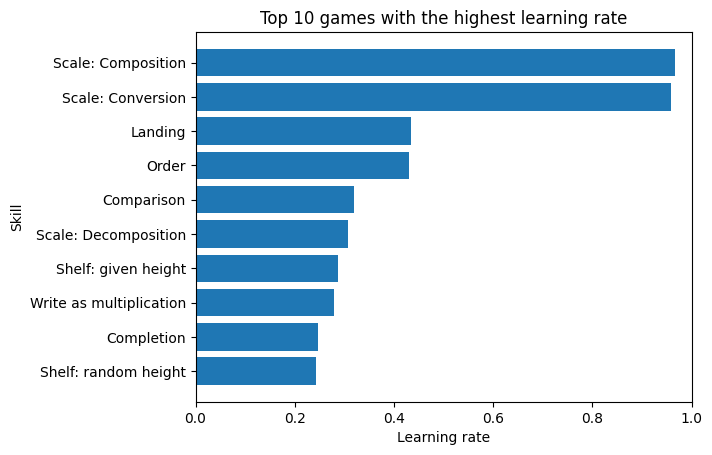

In [56]:
# Plotting the top 10 games with the highest learning rate
df_top10_learning_rate = bkt_1_params[bkt_1_params['param'] == 'learns'][['skill', 'value']].sort_values(by='value', ascending=False).head(10)
df_top10_learning_rate = df_top10_learning_rate.sort_values(by='value', ascending=True)
plt.barh(df_top10_learning_rate['skill'], df_top10_learning_rate['value'])
plt.title('Top 10 games with the highest learning rate')
plt.xlim((0,1))
plt.xlabel('Learning rate')
plt.ylabel('Skill')
plt.show()

We now look at the top 10 games which have the highest learning rate according to the BKT trained model. The composition game as an odly high learning rate, where as the rest of the skills have a learning rate of approximatly 0.4. The interpretation of the composition learning rate would require further investigation, for now we consider it as an outlier. This plot allows us to conclude that the game played by the student has an important influence in his learning potential. 

### Training an LGBM model

In [4]:
mastery_df = load_from_csv('dataframe.csv').reset_index()
full_df = utils_lgbm.create_timeseries(events, subtasks)

In [5]:
index = ['event_id','user_id']
cat_features = ['mode_event', 'game_name','number_range','skill_id', 'type_subtask']
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
date_features = ['date','Year', 'Week', 'Day','week']
target_feature = ['correct']

In [6]:
full_df = full_df[index + cat_features + date_features + target_feature]

#### Feature engineering

In [7]:
# Create a feature that represents the student's overall cumulative accuracy per skill
cumulative_percent_correct = full_df.groupby(['user_id','skill_id'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','skill_id']).rename(columns={'correct':'cumulative_percent_correct'})

In [8]:
full_df = full_df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

In [9]:
df = full_df.merge(mastery_df, how='left', on=['week','user_id','game_name'])

In [10]:
df = df[~ df['mastery_level'].isna()]

In [11]:
df.isna().sum()

event_id                      0
user_id                       0
mode_event                    0
game_name                     0
number_range                  0
skill_id                      0
type_subtask                  0
date                          0
Year                          0
Week                          0
Day                           0
week                          0
correct                       0
level_2                       0
cumulative_percent_correct    0
mastery_level                 0
mastery_level_diff            0
dtype: int64

In [12]:
# LGBM only accepts int, bool and float
for col in cat_features:
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week'] = df['week'].astype('int32')
df[target_feature] = df[target_feature].astype('bool')

In [13]:
generated_features = ['cumulative_percent_correct']
features = index + cat_features + generated_features + ['week']
target_feature = ['mastery_level'] # or 'mastery_level_diff'

lgb_train, lgb_eval, lgb_test = utils_lgbm.create_train_test_split(df, features, target_feature, cat_features)

In [14]:
model = utils_lgbm.train_model(lgb_train, lgb_eval)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 23345, number of negative: 1516
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 24861, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.939021 -> initscore=2.734308
[LightGBM] [Info] Start training from score 2.734308
Training until validation scores don't improve for 8 rounds


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Early stopping, best iteration is:
[23]	training's auc: 0.981814	valid_1's auc: 0.925544


#### Compare to model with no cumulative feature

In [15]:
# Don't include generated features
features_simple = index + cat_features + ['week']
lgb_train_simple, lgb_eval_simple, lgb_test_simple = utils_lgbm.create_train_test_split(df, features_simple, target_feature, cat_features)
model_simple = utils_lgbm.train_model(lgb_train_simple, lgb_eval_simple)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 23345, number of negative: 1516
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 24861, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.939021 -> initscore=2.734308
[LightGBM] [Info] Start training from score 2.734308
Training until validation scores don't improve for 8 rounds


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Early stopping, best iteration is:
[6]	training's auc: 0.930839	valid_1's auc: 0.881826


## Task 3: Model Evaluation


### BKT Evaluation

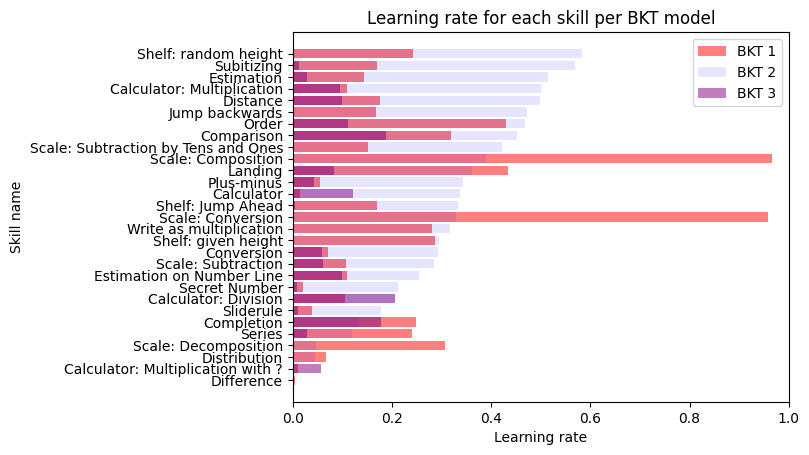

In [59]:
bkt_2_params = bkt_2.params().reset_index()
bkt_3_params = bkt_3.params().reset_index()

# Plotting the three models' learning rates together
# Potentially try to plot them side by side using subplot
df_learning_rate = pd.concat([bkt_1_params[bkt_1_params['param'] == 'learns'][['skill', 'value']], bkt_2_params[bkt_2_params['param'] == 'learns'][['value']], bkt_3_params[bkt_3_params['param'] == 'learns'][['value']]], axis=1)
df_learning_rate.columns = ['skill', 'bkt_1', 'bkt_2', 'bkt_3']
df_learning_rate = df_learning_rate.sort_values(by='bkt_2', ascending=True)
colors = ['red', 'blue', 'purple']
alpha = [0.5, 0.1, 0.5]

for i in range(3):
    plt.barh(df_learning_rate['skill'], df_learning_rate[f'bkt_{i+1}'], label=f'BKT {i+1}', color=colors[i], alpha=alpha[i])
plt.title('Learning rate for each skill per BKT model')
plt.xlim((0,1))
plt.xlabel('Learning rate')
plt.ylabel('Skill name')
plt.legend()
plt.show()


From the above plot, we can see that the learning rates are not evenly distributed among the different games. For the model with the best learning rates and best auc, the composition skill is the one with the highest learning rate. A third of the evaluate skills have a learning rate between 0.4 and 0.6. The remaining skills have a learning rate below 0.4. For the first and third model, the learning rates are also unevenly distributed most of them being bellow 0.4 and few bellow 0.2. 

In the second model, we assume that the students could forget and hence do mistakes. Interestingly, it is the model with the highest learning rates overall. 

In [18]:
def print_auc(auc, model_name):
    print(f'AUC for {model_name}: {auc}')

In [67]:
print_auc(bkt_1_auc, "BKT 1")
print_auc(bkt_2_auc, "BKT 2")
print_auc(bkt_3_auc, "BKT 3")


AUC for BKT 1: 0.7761132717757417
AUC for BKT 2: 0.7833337923678152
AUC for BKT 3: 0.9108275887868982


The AUC value of each BKT models varies slightly from one model to the other. The second model, where the forget parameter is activated performs better then the first one. This result is intuitively coherent as it is highly probable that students can make mistakes by error while playing the games eventhough they have mastered the skill. The AUC score for the third BKT model is odly high. Indeed, this model looks at the cumulative percent correct value to learn the different propabilities, however the cumulative aspect of the attribute can include a bias in the model's value interpretation. 

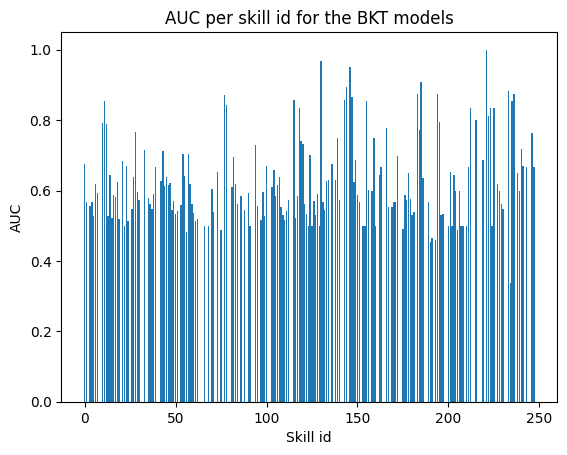

In [60]:
# Plotting the auc per skill id for the BKT models
plt.bar(auc_per_skill.keys(), height=auc_per_skill.values())
plt.xlabel("Skill id")
plt.ylabel("AUC")
plt.title("AUC per skill id for the BKT models")
plt.show()

From the above plot, we can see that even if the auc values seems rather realistic they are mostly around 0.5 which is not very good. Nonetheless, the plot shows that the model performs somewhat better for certain games, futher analysis is needed to understand the reasons behind. 

### LGBM Evaluation

In [29]:
overall_auc = model.eval(lgb_test, 'auc')
print(f"Overall AUC for test data is {overall_auc[0][2]}")

Overall AUC for test data is 0.9557171092524922


In [30]:
overall_auc_simple = model_simple.eval(lgb_test_simple, 'auc')
print(f"Overall AUC for test data is {overall_auc_simple[0][2]}")

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Overall AUC for test data is 0.8794627625063423


__Conclusion__: The feature that captures the student's cumulative average success percentage improves the accuracy of the model. This is expected as this information holds a kind of memory of the student's performance over time.

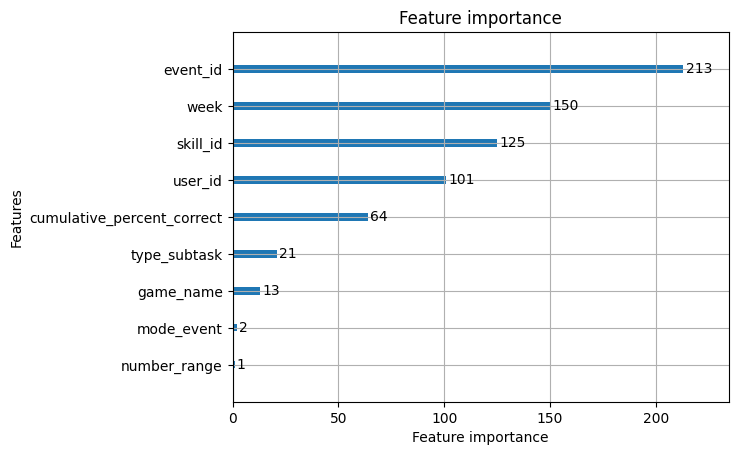

In [25]:
lgb.plot_importance(model)
plt.show()

__Conclusion__: Although cumulative percent correct helps the prediction, it is not the most important factor in dertemining mastery. This explainability chart shows that the event_id and week are more important in making a decision about the student's future mastery levels.

This is also in contrast to the model that merely predicts correctness (See Experiments-LGBM.ipynb). In that case, cumulative percent correct was the most important feature. This indicates that our definition of mastery is capturing more information than correctness alone.

In [27]:
test = df.query('user_id >= 800')[features]

In [28]:
%time shap_values = shap.TreeExplainer(model).shap_values(test)

CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 844 ms


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


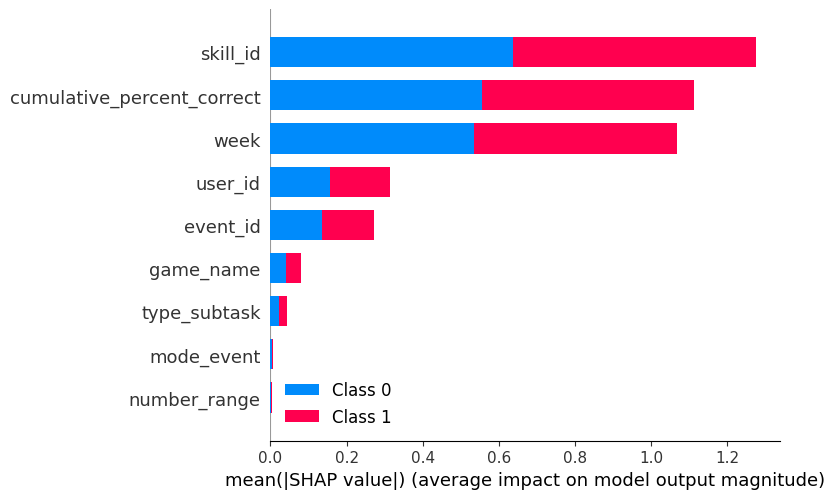

In [29]:
shap.summary_plot(shap_values, test)

__Conclusion__: The SHAP explainabiltity summary shows that the skill_id has the highest impact. This could be due to the differences in the way explainability metrics are calculated, or it could be due to using the test data for SHAP calculations while the model's feature importances are computed based on the training data. Further experimentation on a larger dataset will provide more conclusive evidence. 

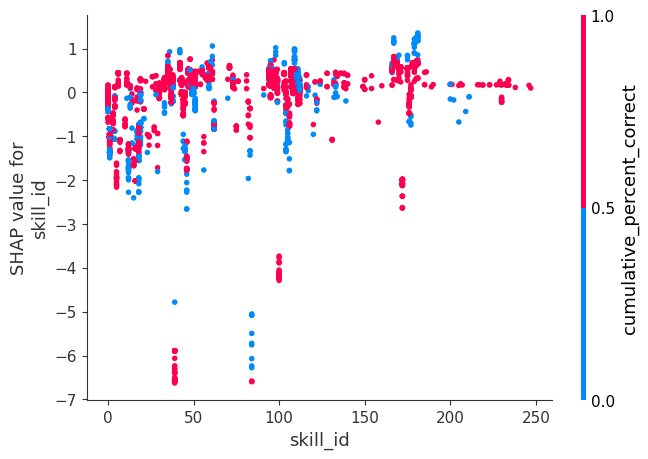

In [30]:
shap.dependence_plot("skill_id", shap_values[1], test)

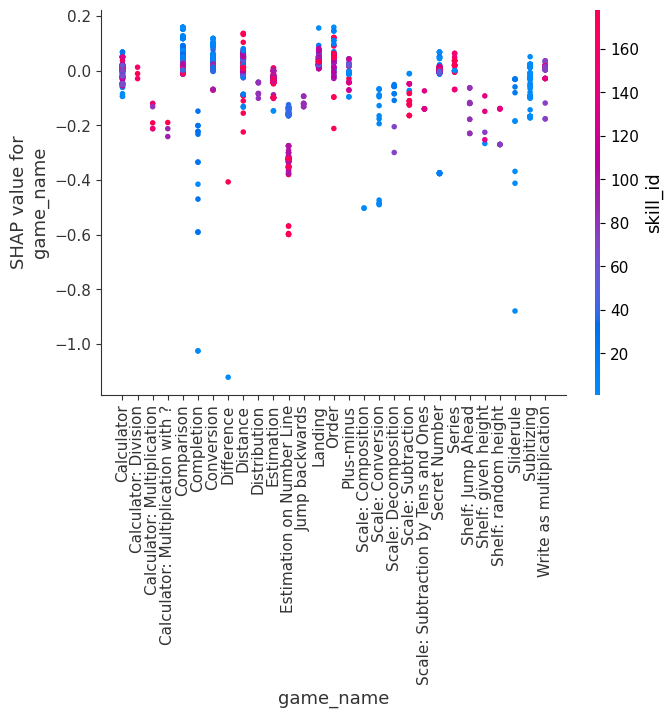

In [36]:
shap.dependence_plot("game_name", shap_values[1], test)

__Conclusion__: Some games and some skill_id values have more of an effect on mastery than others. Some skills could be easier to learn than others. Including a feature like the average correctness per game or skill might help the model predict mastery. This will be explored in the future.

In [42]:
test = df.query('user_id >= 800')[features]
y_test = df.query('user_id >= 800')[target_feature]

In [43]:
# Compare performance per skill
skills_dataset = {}

for skill in events['skill_id'].unique():
    if not math.isnan(skill):
        y_test = df.query(f'user_id >= 800 and skill_id == {skill}')[target_feature]
        skills_dataset[skill] = lgb.Dataset(test.query(f'skill_id == {skill}'), y_test, categorical_feature = cat_features, free_raw_data=False, reference=lgb_train)

In [ ]:
aucs ={}
for skill, dataset in tqdm.tqdm(skills_dataset.items()):
    try:
        aucs[skill] = model.eval(dataset, 'auc')[0][2]
    except Exception as e:
        print(f"Skill {skill} threw error: {e}")


Text(0, 0.5, 'AUC')

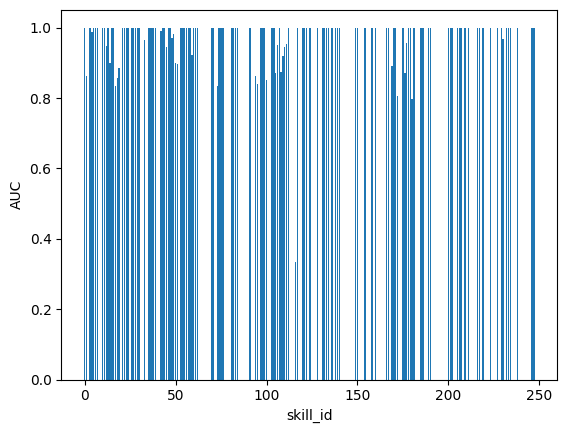

In [48]:
plt.bar(aucs.keys(), height=aucs.values())
plt.xlabel("skill_id")
plt.ylabel("AUC")

__Conclusion__: The model performs better on some skills than others. Further investigation is required on a larger sample of the data to draw conclusions.

#### BKT vs LGBM evaluation

In [32]:
# add the auc per skill for BKT

# LGBM and BKT AUC comparison
print_auc(bkt_1_auc, "BKT 1")
print_auc(bkt_2_auc, "BKT 2")
print_auc(bkt_3_auc, "BKT 3")
print_auc(overall_auc_simple[0][2], "LGBM simple")
print_auc(overall_auc[0][2], "LGBM")

AUC for BKT 1: 0.7765187401360962
AUC for BKT 2: 0.7825655084906434
AUC for BKT 3: 0.9106091045550708
AUC for LGBM simple: 0.8794627625063423
AUC for LGBM: 0.9557171092524922


As expected, the LGBM performs considerably better then the BKT model overall. Even if the BKT model has interesting features to understand the different learning rate and potential mastery level of the students, the LGDM model seem to perfom better at knowledge tracing from our analysis. Moreover, the latter allows us to gain insights on other features that influences the student's learning progress as seen above. 

## Task 4: Team Reflection

### Contributions

Olivia: Feature generation (rolling historical average), LGBM model and evaluation, SHAP explainability, Transformer exploration, preliminary dask experimentation

Ewa: Preprocessing, traversing skill graph, feature generation (mastery level delta)

Blanche: BKT model, BKT evaluation


### Reflection

#### What went well
- splitting up tasks at the start and sharing the workload
- researching existing solutions online for inspiration
- getting early feedback from the TAs

#### What can be improved
- efficient operations for working with the full dataset
- installing dependencies (pygraph) early
- meeting more frequently